In [ ]:
!apt-get install openjdk-8-jdk-headless
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("DataCleaningApp")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
!pip install gmplot        

In [ ]:
#importing essential libraries
import pyspark.sql
import datetime
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import pyspark
import pandas as pd
from geopy.geocoders import Nominatim
import numpy as np
import gmplot

**Loading data into spark dataframe**

In [ ]:
data=spark.read.csv("/content/combined-data.csv", header=True, inferSchema=True)
adclicks = spark.read.csv('ad-clicks.csv', header=True, inferSchema=True)
buyclicks = spark.read.csv('buy-clicks.csv', header=True, inferSchema=True)
gameclicks = spark.read.csv('game-clicks.csv', header=True, inferSchema=True)
levelevents = spark.read.csv('level-events.csv', header=True, inferSchema=True)
team = spark.read.csv('team.csv', header=True, inferSchema=True)
team_assignments = spark.read.csv('team-assignments.csv', header=True, inferSchema=True)
users = spark.read.csv('users.csv', header=True, inferSchema=True)
user_session = spark.read.csv('user-session.csv', header=True, inferSchema=True)

In [ ]:
adclicks.show()

Text(0.5, 1.0, 'Devices used to play the game')

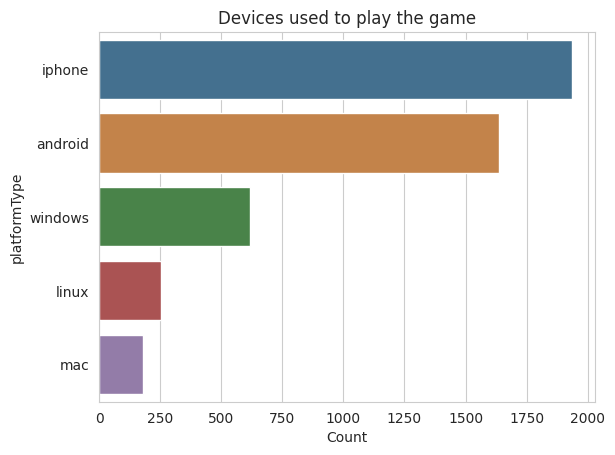

In [ ]:
#Devices used to play the game
from pyspark.sql.functions import count
import seaborn as sns
# Group by platformType and count the number of occurrences
platform_counts = data.groupBy('platformType').agg(count('*').alias('Count'))

# Sort by count in descending order
platform_counts = platform_counts.sort('Count', ascending=False)

# Convert the result to a Pandas DataFrame for visualization with Seaborn
platform_counts_pd = platform_counts.toPandas()

# Create horizontal bar chart
sns.set_style('whitegrid')
sns.barplot(x='Count', y='platformType', data=platform_counts_pd, saturation=.5).set_title('Devices used to play the game')


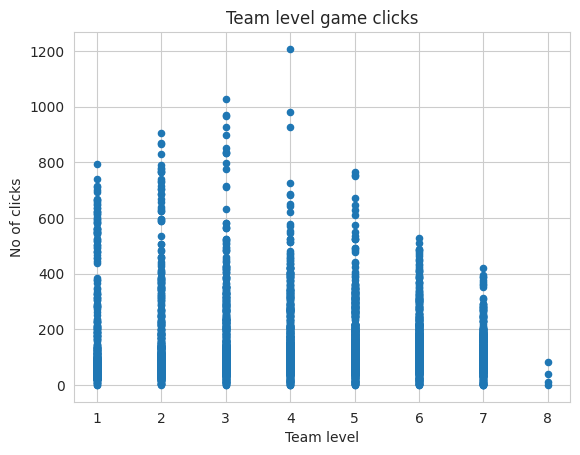

In [ ]:
#Team level game clicks
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
# Cast count_gameclicks to integer type
gam = data.withColumn('count_gameclicks', F.col('count_gameclicks').cast(IntegerType()))

# Create scatter plot
gam.select('teamLevel', 'count_gameclicks').toPandas().plot.scatter(x='teamLevel', y='count_gameclicks', title='Team level game clicks')
plt.xlabel('Team level')
plt.ylabel('No of clicks')
# Display plot
plt.show()


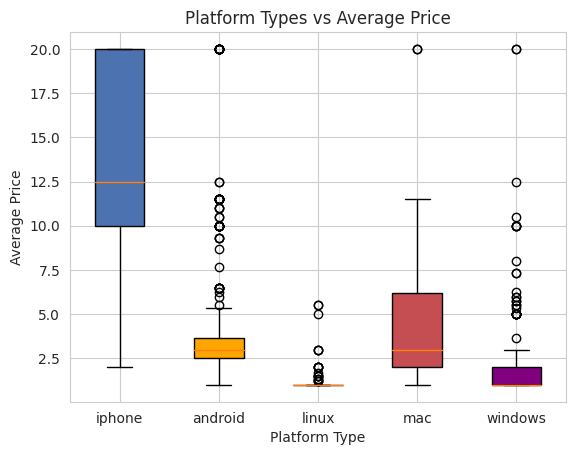

In [ ]:
#Platform Types vs Average Price
import pyspark.sql.functions as F
import matplotlib.pyplot as plt


# Group by a categorical column and collect the values of a numerical column as a list
grouped_data = data.groupBy("platformType").agg(F.collect_list("avg_price").alias("values"))

# Convert Spark DataFrame to Pandas DataFrame
pandas_data = grouped_data.toPandas()
# Create box plot
box_plot = plt.boxplot(pandas_data["values"], patch_artist=True)

# Set box colors
colors = [ "#4C72B0", "orange","green","#C44E52", "purple"]
for patch, color in zip(box_plot["boxes"], colors):
    patch.set_facecolor(color)

# Set x-axis tick labels and plot titles and labels
plt.xticks(range(1, len(pandas_data) + 1), pandas_data["platformType"])
plt.title('Platform Types vs Average Price')
plt.xlabel('Platform Type')
plt.ylabel('Average Price')

# Display plot
plt.show()







In [ ]:
#Join users df to user_session df
user_info = users.join(user_session, 'userId', 'inner')

In [ ]:
#covert dob field to age
from pyspark.sql import functions as F
user_info = user_info.withColumn('age', (F.months_between(current_date(), F.col('dob')) / 12).cast('int'))
#drop DOB column
user_info = user_info.drop('dob')

In [ ]:
user_info.show(2)

+------+-------------------+----------+-------+-------+-------------------+-------------+------+------------+-----------+---------+------------+---+
|userId|          timestamp|      nick|twitter|country|          timestamp|userSessionId|teamId|assignmentId|sessionType|teamLevel|platformType|age|
+------+-------------------+----------+-------+-------+-------------------+-------------+------+------------+-----------+---------+------------+---+
|   170|2016-02-13 15:04:42|HmV6dJIAjP|@ejgBLF|     ST|2016-05-26 14:47:30|         5675|    90|        5423|      start|        1|      iphone| 49|
|   170|2016-02-13 15:04:42|HmV6dJIAjP|@ejgBLF|     ST|2016-05-27 00:06:54|         5675|    90|        5423|        end|        1|      iphone| 49|
+------+-------------------+----------+-------+-------+-------------------+-------------+------+------------+-----------+---------+------------+---+
only showing top 2 rows



Text(0.5, 1.0, 'Top 10 User Countries')

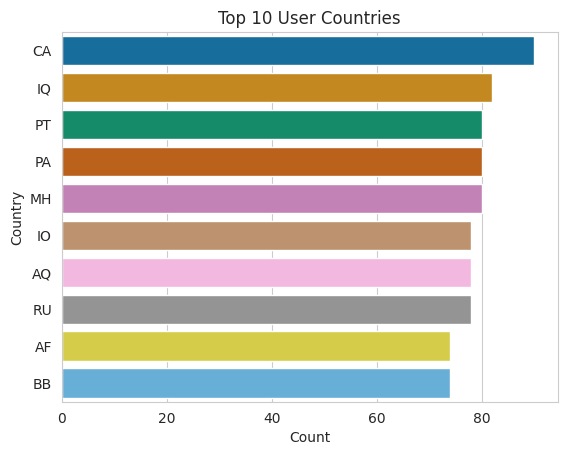

In [ ]:
#Top 10 User Countries who played the most
import pyspark.sql.functions as F
import seaborn as sns
import pandas as pd

# Get count of user countries
ds = user_info.groupby('country').count().orderBy(F.desc('count')).limit(10)
ds = ds.withColumnRenamed('country', 'Country').withColumnRenamed('count', 'Count')

# Convert Spark DataFrame to Pandas DataFrame
pandas_data = ds.toPandas()

# Create horizontal bar plot
sns.barplot(x='Count', y='Country', data=pandas_data, palette='colorblind').set_title('Top 10 User Countries')


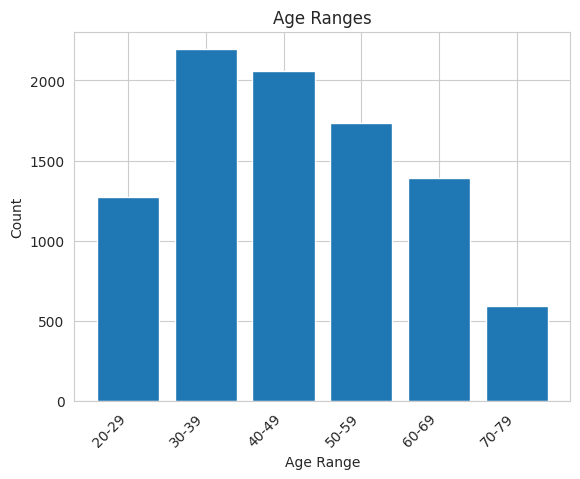

In [ ]:
# User age range to determine which age group played the most
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Define age ranges and corresponding labels
age_ranges = [(0, 10, "0-10"), (11, 20, "11-20"), (21, 30, "21-30"), (31, 40, "31-40"), (41, 50, "41-50"), (51, 60, "51-60"), (61, 70, "61-70"), (71, 80, "71-80"), (81, 90, "81-90"), (91, 100, "91-100")]

# Create age range column
age_range_column = F.when(F.col('age').isNull(), None).otherwise(
    F.concat_ws('-', F.floor(F.col('age')/10)*10, F.floor(F.col('age')/10)*10+9)
).alias('age_range')

# Group by age range and count occurrences
age_counts = user_info.withColumn('age_range', age_range_column).groupBy('age_range').count().orderBy('age_range').toPandas()

# Create bar plot
plt.bar(age_counts['age_range'], age_counts['count'])

# Set x-axis tick labels and plot titles and labels
plt.xticks(rotation=45, ha="right")
plt.title('Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Count')

# Display plot
plt.show()


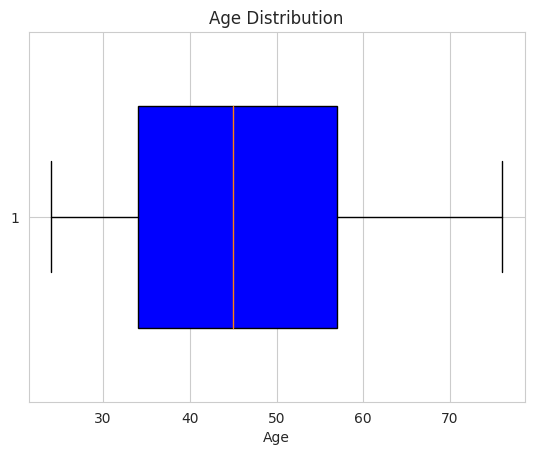

In [ ]:
# Age distribution statistics
import pyspark.sql.functions as F
import matplotlib.pyplot as plt


# Convert age to float type
data = user_info.withColumn('age', F.col('age').cast('float'))

# Create box plot
fig, ax = plt.subplots()
ax.boxplot(data.select('age').rdd.flatMap(lambda x: x).collect(), vert=False, widths=0.6, patch_artist=True, boxprops=dict(facecolor='blue'))

# Set plot title and labels
ax.set_title('Age Distribution')
ax.set_xlabel('Age')
ax.set_ylabel('')

# Display plot
plt.show()


In [ ]:
#Age vs Team Level
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Group by teamLevel and collect age values as a list
grouped_data = user_info.groupBy("teamLevel").agg(F.collect_list("age").alias("age"))

# Convert Spark DataFrame to Pandas DataFrame
pandas_data = grouped_data.toPandas()

# Flatten the 'age' column to a 1D numpy array
ages = np.concatenate(pandas_data['age'].values)

# Add the flattened 'age' array back into the Pandas DataFrame
pandas_data['age'] = ages

# Create violin plot
sns.violinplot(x="age", y="teamLevel", data=pandas_data, color="blue")

# Set plot title and labels
plt.title('Age vs Team Level')
plt.xlabel('Age')
plt.ylabel('Team Level')

# Display plot
plt.show()


<Axes: xlabel='teamlevel', ylabel='age'>

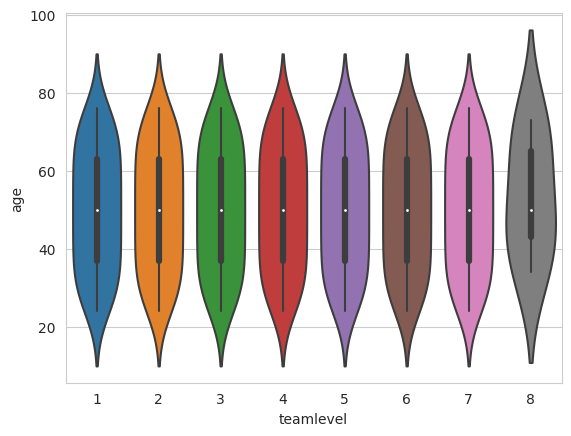

In [ ]:
# age vs team leavel
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd

# Step 2: Load data into a Spark DataFrame
spark = SparkSession.builder.appName('violin_plot').getOrCreate()

# Step 3: Group data by team level and aggregate age
grouped_data = user_info.groupBy('teamlevel').agg({'age': 'collect_set'})

# Step 4: Convert Spark DataFrame to Pandas DataFrame and create violin plot
pandas_df = grouped_data.toPandas()
pandas_df['age'] = pandas_df['collect_set(age)'].apply(list)
pandas_df = pandas_df.explode('age')
pandas_df['age'] = pd.to_numeric(pandas_df['age'])
sns.violinplot(x='teamlevel', y='age', data=pandas_df)


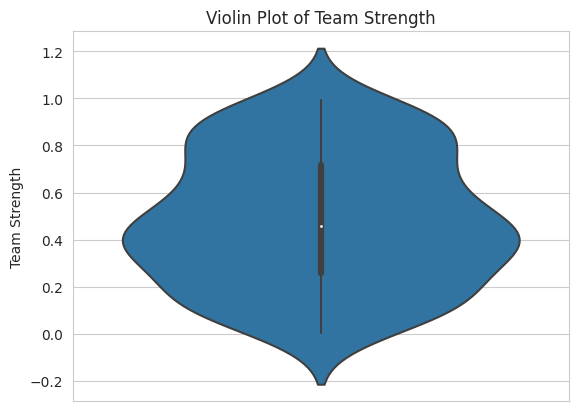

In [ ]:
#Violin Plot of Team Strength
import seaborn as sns
# Convert Spark DataFrame to Pandas DataFrame
team_pandas = team.select(col('strength')).toPandas()
sns.violinplot(y='strength', data=team_pandas)
plt.title("Violin Plot of Team Strength")
plt.ylabel("Team Strength")
plt.show()

In [ ]:
#combining multiple dfs into one
from numpy.lib.function_base import add_docstring
combined_df=user_info.select('userId','teamId','age','teamLevel')
combined_df=combined_df.dropDuplicates()
team_Df = team.select('teamId','strength')
team_Df = team_Df.dropDuplicates()
team.select('teamId','strength')
combined_df = combined_df.join(team_Df, on = 'teamId', how = "inner")
game_Df = gameclicks.groupBy("userId").agg(sum("isHit").alias("Total Hits"), count("clickId").alias("clickId count"))
game_Df=game_Df.dropDuplicates()
combined_df = combined_df.join(game_Df,on = "userId", how ="inner")
adclick_Df = adclicks.groupBy("userId").agg(count("adId").alias("adId count"))
adclick_Df=adclick_Df.dropDuplicates()
combined_df = combined_df.join(adclick_Df, on = "userId", how = "inner")
buyclicks_Df =  buyclicks.groupBy("userId").agg(count("buyId").alias("buyId count"), sum("price").alias("Total price"))
buyclicks_Df=buyclicks_Df.dropDuplicates()
combined_df = combined_df.join(buyclicks_Df, on="userId", how="inner")

In [ ]:
from pyspark.sql.functions import col, sum
# check is there are any null values
combined_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in combined_df.columns]).show()


+------+------+---+---------+--------+----------+-------------+----------+-----------+-----------+
|userId|teamId|age|teamLevel|strength|Total Hits|clickId count|adId count|buyId count|Total price|
+------+------+---+---------+--------+----------+-------------+----------+-----------+-----------+
|     0|     0|  0|        0|       0|         0|            0|         0|          0|          0|
+------+------+---+---------+--------+----------+-------------+----------+-----------+-----------+



In [ ]:
combined_df.describe

<bound method DataFrame.describe of DataFrame[userId: int, teamId: int, age: int, teamLevel: int, strength: double, Total Hits: bigint, clickId count: bigint, adId count: bigint, buyId count: bigint, Total price: double]>

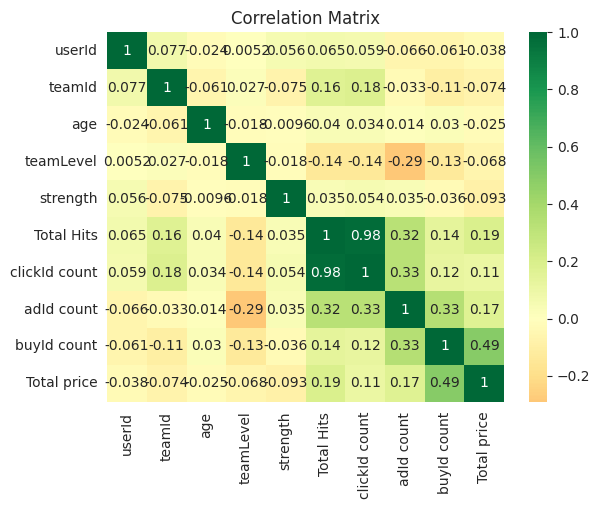

In [ ]:
# correlation matirx to identify correlation between variables
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Create a VectorAssembler to combine all columns into a single vector column "features"
vector_df = VectorAssembler(inputCols=combined_df.columns, outputCol="features").transform(combined_df).select("features")


# Compute the correlation matrix using the Correlation module
corr_matrix = Correlation.corr(vector_df, "features").head()

# Extract the correlation matrix as a NumPy array
corr_array = corr_matrix[0].toArray()

# Create a seaborn heatmap of the correlation matrix
sns.heatmap(corr_array, xticklabels=combined_df.columns, yticklabels=combined_df.columns, cmap='RdYlGn', center=0, annot=True)
plt.title("Correlation Matrix")
plt.show()


In [ ]:
#Top 10 users by hits bar plot
from pyspark.sql.functions import sum

user_counts = data.groupby('userId').agg(sum('count_hits').alias('Count Hits')).sort('Count Hits', ascending=False)
user_counts_top10 = user_counts.limit(10)

sns.barplot(x="userId", y="Count Hits", data=user_counts_top10.toPandas())
plt.title("Top 10 users by hits")


In [ ]:
user_counts_top10

DataFrame[userId: int, Count Hits: bigint]

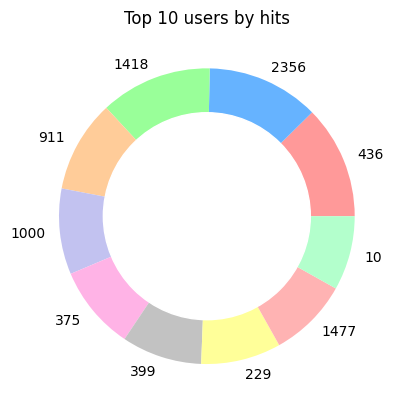

In [ ]:
import matplotlib.pyplot as plt
#'Top 10 users by hits donut plot
# Define the data
sizes = user_counts_top10.select('Count Hits').rdd.flatMap(lambda x: x).collect()
labels = user_counts_top10.select('userId').rdd.flatMap(lambda x: x).collect()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c2c2c2','#ffff99','#ffb3b3','#b3ffcc']

# Create a circle for the center of the plot
circle = plt.Circle((0,0), 0.7, color='white')

# Create the donut chart
plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'width':0.5})

# Add the circle to the center of the plot
fig = plt.gcf()
fig.gca().add_artist(circle)

# Add a title and show the plot
plt.title('Top 10 users by hits')
plt.show()


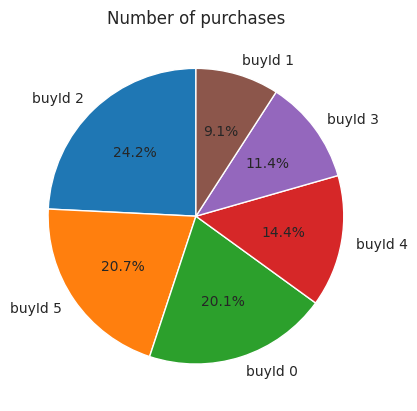

In [ ]:
#Number of purchases piechart
buy_counts = buyclicks.groupBy('buyId').count().sort('count', ascending=False).limit(10)

# Convert the result to a Pandas DataFrame for plotting
buy_counts_df = buy_counts.toPandas()

colors = sns.color_palette("tab10")

# Plot the resulting DataFrame as a pie chart
plt.pie(buy_counts_df['count'].values, labels=["buyId " + str(i) for i in buy_counts_df['buyId']], autopct='%1.1f%%', startangle=90, colors = colors)
plt.title('Number of purchases')
plt.show()

In [ ]:
!pip3 install opencage
!pip install gmplot
import gmplot
import webbrowser

In [ ]:
from opencage.geocoder import OpenCageGeocode
#heatmap to identify locations
key = '81627bd5208a4573a35d9d50deec0592'
geocoder = OpenCageGeocode(key)
coordinates = {'latitude': [], 'longitude': []}

unique_countries = users.filter(users['country'].isNotNull()).select('country').distinct().rdd.flatMap(lambda x: x).collect()

for country in unique_countries:
    results = geocoder.geocode(country)
    coordinates['latitude'].append(results[0]['geometry']['lat'])
    coordinates['longitude'].append(results[0]['geometry']['lng'])

df_geolocation = pd.DataFrame.from_dict(coordinates)
df_geolocation = df_geolocation.dropna()
Lat = df_geolocation['latitude']
Long = df_geolocation['longitude']
map_plot = gmplot.GoogleMapPlotter(53.81604806664296, -3.0548307614209813, 3)
map_plot.heatmap(Lat, Long)
map_plot.draw("test.html")
webbrowser.open_new_tab("test.html")


False